In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv', index_col=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
df_train.shape, df_test.shape

((1168, 80), (292, 80))

In [3]:
y_train = df_train['SalePrice']
y_test = df_test['SalePrice']

X_train = df_train.drop('SalePrice', axis=1)
X_test = df_test.drop('SalePrice', axis=1)

num_features = X_train.dtypes[df_train.dtypes != 'object'].index.values
cat_features = X_train.dtypes[df_train.dtypes == 'object'].index.values

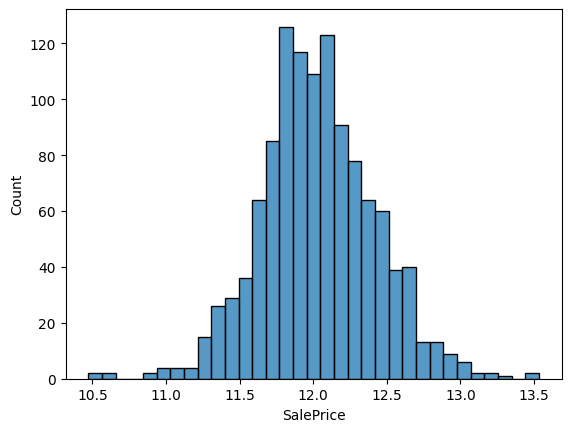

In [4]:
sns.histplot(df_train.SalePrice.apply(lambda w: np.log(w + 1)));

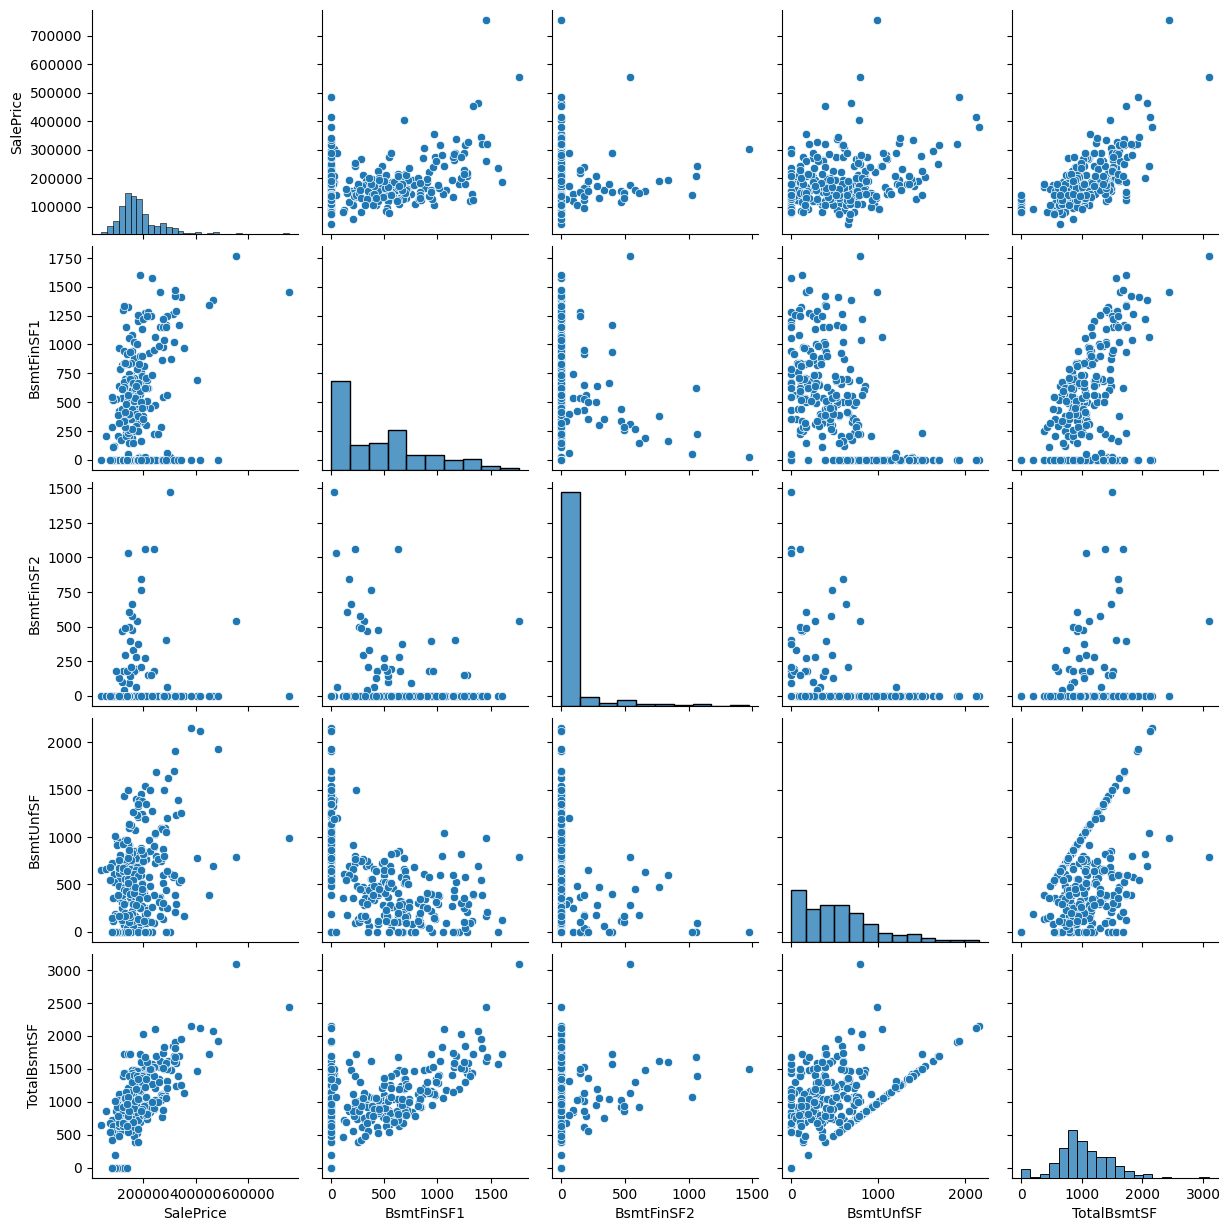

In [14]:
sns.pairplot(df_train[['SalePrice'] + list(num_features[8:12])].sample(300));

In [15]:
X_train[num_features].isnull().sum()

MSSubClass         0
LotFrontage      207
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         7
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       64
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [16]:
med = X_train.median()
X_train = X_train.fillna(med)
X_test = X_test.fillna(med)

/var/folders/95/tw3zkzk9035_zpzhx2ty33pn4qbhgy/T/ipykernel_58480/157528533.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  med = X_train.median()


In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [18]:
y_pred_naive = y_train.median() * np.ones_like(y_test)
mean_absolute_percentage_error(y_test, y_pred_naive)

0.3435088411862071

In [19]:
model_knn = KNeighborsRegressor(n_neighbors=20)
model_knn.fit(X_train[num_features], y_train)
y_pred = model_knn.predict(X_test[num_features])
mean_absolute_percentage_error(y_test, y_pred)

0.19416487404446103

In [20]:
model_reg = LinearRegression()
model_reg.fit(X_train[num_features], y_train)
y_pred = model_reg.predict(X_test[num_features])
mean_absolute_percentage_error(y_test, y_pred)

0.13670171072779855

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train[num_features])
X_test_scal = scaler.transform(X_test[num_features])

In [22]:
model_knn = KNeighborsRegressor(n_neighbors=20)
model_knn.fit(X_train_scal, y_train)
y_pred = model_knn.predict(X_test_scal)
mean_absolute_percentage_error(y_test, y_pred)

0.13659526655683973

In [23]:
model_reg = LinearRegression()
model_reg.fit(X_train_scal, y_train)
y_pred = model_reg.predict(X_test_scal)
mean_absolute_percentage_error(y_test, y_pred)

0.13670027854195974

In [24]:
model_reg = LinearRegression()
model_reg.fit(X_train_scal, np.log(1 + y_train))
y_pred = model_reg.predict(X_test_scal)
mean_absolute_percentage_error(y_test, np.exp(y_pred) - 1)

0.1156308253551088

Давайте  нагенерим степеней! 

In [32]:
X_train_scal.shape

(1168, 36)

In [33]:
36 + 36 + 36*35/2

702.0

In [31]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly.fit_transform(X_train_scal).shape

(1168, 703)

In [40]:
from sklearn.pipeline import Pipeline

linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linear_model', LinearRegression()) 
])

linear_pipe.fit(X_train[num_features], y_train)
y_pred = linear_pipe.predict(X_test[num_features])
y_pred_train = linear_pipe.predict(X_train[num_features])

print('train mape', mean_absolute_percentage_error(y_train, y_pred_train))
print('test mape', mean_absolute_percentage_error(y_test, y_pred))

train mape 0.05760282407469173
test mape 434379377.8823486


In [46]:
np.abs(linear_pipe['linear_model'].coef_[:5]).sum()

78658261114893.11

In [60]:
from sklearn.linear_model import Ridge

linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linear_model', Ridge(alpha=162.3777)) 
])

linear_pipe.fit(X_train[num_features], y_train)
y_pred = linear_pipe.predict(X_test[num_features])
y_pred_train = linear_pipe.predict(X_train[num_features])

print('train mape', mean_absolute_percentage_error(y_train, y_pred_train))
print('test mape', mean_absolute_percentage_error(y_test, y_pred))

train mape 0.06977132702350024
test mape 0.1307624266398569


In [55]:
linear_pipe['scaler'].mean_

array([5.75299658e+01, 7.00933219e+01, 1.04847149e+04, 6.12500000e+00,
       5.55736301e+00, 1.97179281e+03, 1.98538271e+03, 1.02477740e+02,
       4.36528253e+02, 4.64066781e+01, 5.73304795e+02, 1.05623973e+03,
       1.16142380e+03, 3.54339897e+02, 6.43835616e+00, 1.52220205e+03,
       4.21232877e-01, 6.07876712e-02, 1.57448630e+00, 3.97260274e-01,
       2.87414384e+00, 1.04537671e+00, 6.54023973e+00, 6.40410959e-01,
       1.97902825e+03, 1.77739726e+00, 4.74567637e+02, 9.60042808e+01,
       4.62328767e+01, 2.32208904e+01, 3.29965753e+00, 1.47979452e+01,
       3.44863014e+00, 4.54743151e+01, 6.35188356e+00, 2.00781250e+03])

In [70]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 4, 20)

linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linear_model', Ridge()) 
])

searcher = GridSearchCV(
    linear_pipe, [{'linear_model__alpha': alphas}],
    scoring="neg_root_mean_squared_error", 
    cv=10, n_jobs=-1
)

searcher.fit(X_train[num_features], y_train)
best_alpha = searcher.best_params_["linear_model__alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 127.4275


Text(0, 0.5, 'CV score')

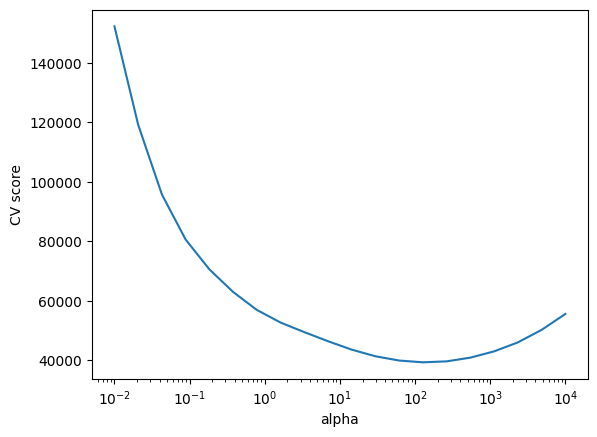

In [71]:
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [72]:
y_pred = searcher.predict(X_test[num_features])
y_pred_train = searcher.predict(X_train[num_features])

print('train mape', mean_absolute_percentage_error(y_train, y_pred_train))
print('test mape', mean_absolute_percentage_error(y_test, y_pred))

train mape 0.06823239817838232
test mape 0.13285919093009074
